# EEG-based BCI using Visual Imagery and Emotiv Epoc X:  An Exploratory Study

##Computational Cognitive Neuroscience 2020/2021

### Decoding analysis using Common Spatial Pattern (CSP) method and LDA approach on Morlet Wavelet transformed data

### Import Libraries

In [1]:
%%capture libraries   

import sys
import os
!{sys.executable} -m pip install numpy
!{sys.executable} -m pip install mne
!{sys.executable} -m pip install mne-features
import numpy as np
import matplotlib 
import pathlib
import mne
import seaborn as sns
import pandas as pd
from mne.io import concatenate_raws, read_raw_edf
from mne import Epochs, create_info, events_from_annotations
from mne.preprocessing import ICA, create_eog_epochs, create_ecg_epochs,corrmap
from mne.time_frequency import tfr_morlet, psd_multitaper, psd_welch, tfr_stockwell,tfr_multitaper,tfr_array_morlet,AverageTFR
from scipy import signal
from scipy.integrate import simps
matplotlib.use('Qt5Agg') #allow interactive plots
import matplotlib.pyplot as plt
from mne.decoding import GeneralizingEstimator, Scaler,cross_val_multiscore, LinearModel, get_coef, Vectorizer, CSP, SlidingEstimator
from mne.viz import centers_to_edges
from mne.baseline import rescale
from sklearn import metrics
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.model_selection import cross_val_score, train_test_split, GridSearchCV, StratifiedKFold, ShuffleSplit
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score, precision_recall_fscore_support, precision_recall_curve, average_precision_score, plot_precision_recall_curve, ConfusionMatrixDisplay, roc_curve
from sklearn.ensemble import RandomForestClassifier
from sklearn.inspection import permutation_importance
from sklearn.metrics import plot_roc_curve, accuracy_score,precision_score,recall_score,f1_score,roc_auc_score
from sklearn.neighbors import KNeighborsClassifier
from sklearn import svm
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.linear_model import LogisticRegression
%run EEG_functions_1.ipynb import load_data, excl_chan, filter_data, make_epochs, plot_data, epochs_power

In [2]:
#load raw datasets

raw_datasets = load_data(os.getcwd()) 

#define channels of interest
include_channels = ['O1','O2']   #include only occipital channels
 
excl_chan(raw_datasets) #exclude unwanted channels


#crop sessions between 65 s and 165 s
for n_file in range (0,30):
    raw_datasets[n_file].crop(tmin=65.,tmax=164.998)
    
#concatenate sessions
raw = concatenate_raws(raw_datasets)

# Extract information from the raw file
sfreq = 256.

#create events
event_id = dict(Relax=0, Push=1)  #imagery relax vs push
events = mne.make_fixed_length_events(raw, id=0, start=0., stop=None, duration=10.)  
for n_events in range(0, len(events)):
    if n_events % 2 == 1: 
        events[n_events][2] = 1 

Extracting EDF parameters from /Users/ile/Documents/BCI_dataset/Giuseppe03_03.02.21_08.33.04.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 45311  =      0.000 ...   176.996 secs...
Extracting EDF parameters from /Users/ile/Documents/BCI_dataset/Giuseppe14_11.02.21_08.36.41.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 45567  =      0.000 ...   177.996 secs...
Extracting EDF parameters from /Users/ile/Documents/BCI_dataset/Giuseppe29_19.02.21_08.40.08.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 44543  =      0.000 ...   173.996 secs...
Extracting EDF parameters from /Users/ile/Documents/BCI_dataset/Giuseppe17_12.02.21_08.44.40.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 44799  =      0.000 ...   174.996 secs...
Extracting EDF parameters from /Users/ile/Do

In [3]:
## Assemble the classifier using scikit-learn pipeline

clf = make_pipeline(CSP(n_components=4, reg=None, log=True, norm_trace=False), LinearDiscriminantAnalysis())

n_splits = 5  # how many folds to use for cross-validation
cv = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=42)


# Classification & time-frequency parameters
tmin, tmax = 0.5, 9.5
n_cycles = 2.   
min_freq = 4   
max_freq = 25 
n_freqs = 8  


# Assemble list of frequency range tuples

freqs = np.linspace(min_freq, max_freq, n_freqs)  # assemble frequencies
freq_ranges = list(zip(freqs[:-1], freqs[1:]))  # make freqs list of tuples


# Infer window spacing from the max freq and number of cycles to avoid gaps

window_spacing = (n_cycles / np.max(freqs) / 2.)
centered_w_times = np.arange(tmin, tmax, window_spacing)[1:]
n_windows = len(centered_w_times)

# init scores
freq_scores = np.zeros((n_freqs - 1,))


#Loop through frequencies, apply classifier and save scores
for freq, (fmin, fmax) in enumerate(freq_ranges):
        

    # Infer window size based on the frequency being used
    w_size = n_cycles / ((fmax + fmin) / 2.)  # in seconds
        
    raw_filter = raw.copy().filter(fmin, fmax, n_jobs=1, fir_design='firwin',
                                   skip_by_annotation='edge')


    # Extract epochs from filtered data, padded by window size
    epochs = mne.Epochs(raw_filter, events, event_id, tmin - w_size, tmax + w_size,proj=False, baseline=None, preload=True)
    epochs.drop_bad() #epochs.drop_bad(reject = dict(eeg = 200e-6)) #uncomment to include a rejection threshold

    epo=epochs_power(epochs)  #apply Morlet wavelet transform to the epoched filtered data
     
    y= epochs.events[:, 2]  #labels
    X = epo
  

    # Save mean scores over folds for each frequency and time window
    freq_scores[freq] = np.mean(cross_val_score(estimator=clf, X=X, y=y,
                                                scoring='accuracy', cv=cv,
                                                n_jobs=1), axis=0)

Filtering raw data in 30 contiguous segments
Setting up band-pass filter from 4 - 7 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 4.00
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 3.00 Hz)
- Upper passband edge: 7.00 Hz
- Upper transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 8.00 Hz)
- Filter length: 423 samples (1.652 sec)

Not setting metadata
Not setting metadata
300 matching events found
No baseline correction applied
Loading data for 300 events and 2491 original time points ...
0 bad epochs dropped
Not setting metadata
Computing rank from data with rank=None
    Using tolerance 1.5e-10 (2.2e-16 eps * 2 dim * 3.3e+05  max singular value)
    Estimated rank (mag): 2
    MAG: rank 2 computed from 2 data channels with 0 projectors
Reducing data rank from 

Reducing data rank from 2 -> 2
Estimating covariance using EMPIRICAL
Done.
Computing rank from data with rank=None
    Using tolerance 2e-10 (2.2e-16 eps * 2 dim * 4.4e+05  max singular value)
    Estimated rank (mag): 2
    MAG: rank 2 computed from 2 data channels with 0 projectors
Reducing data rank from 2 -> 2
Estimating covariance using EMPIRICAL
Done.
Computing rank from data with rank=None
    Using tolerance 2.6e-10 (2.2e-16 eps * 2 dim * 5.8e+05  max singular value)
    Estimated rank (mag): 2
    MAG: rank 2 computed from 2 data channels with 0 projectors
Reducing data rank from 2 -> 2
Estimating covariance using EMPIRICAL
Done.
Computing rank from data with rank=None
    Using tolerance 2e-10 (2.2e-16 eps * 2 dim * 4.5e+05  max singular value)
    Estimated rank (mag): 2
    MAG: rank 2 computed from 2 data channels with 0 projectors
Reducing data rank from 2 -> 2
Estimating covariance using EMPIRICAL
Done.
Computing rank from data with rank=None
    Using tolerance 2.6e-10 

Done.
Computing rank from data with rank=None
    Using tolerance 3e-11 (2.2e-16 eps * 2 dim * 6.8e+04  max singular value)
    Estimated rank (mag): 2
    MAG: rank 2 computed from 2 data channels with 0 projectors
Reducing data rank from 2 -> 2
Estimating covariance using EMPIRICAL
Done.
Computing rank from data with rank=None
    Using tolerance 3.3e-11 (2.2e-16 eps * 2 dim * 7.5e+04  max singular value)
    Estimated rank (mag): 2
    MAG: rank 2 computed from 2 data channels with 0 projectors
Reducing data rank from 2 -> 2
Estimating covariance using EMPIRICAL
Done.
Computing rank from data with rank=None
    Using tolerance 3e-11 (2.2e-16 eps * 2 dim * 6.8e+04  max singular value)
    Estimated rank (mag): 2
    MAG: rank 2 computed from 2 data channels with 0 projectors
Reducing data rank from 2 -> 2
Estimating covariance using EMPIRICAL
Done.
Computing rank from data with rank=None
    Using tolerance 3.4e-11 (2.2e-16 eps * 2 dim * 7.7e+04  max singular value)
    Estimated ran

    Estimated rank (mag): 2
    MAG: rank 2 computed from 2 data channels with 0 projectors
Reducing data rank from 2 -> 2
Estimating covariance using EMPIRICAL
Done.
Computing rank from data with rank=None
    Using tolerance 1.8e-11 (2.2e-16 eps * 2 dim * 4e+04  max singular value)
    Estimated rank (mag): 2
    MAG: rank 2 computed from 2 data channels with 0 projectors
Reducing data rank from 2 -> 2
Estimating covariance using EMPIRICAL
Done.
Computing rank from data with rank=None
    Using tolerance 2e-11 (2.2e-16 eps * 2 dim * 4.5e+04  max singular value)
    Estimated rank (mag): 2
    MAG: rank 2 computed from 2 data channels with 0 projectors
Reducing data rank from 2 -> 2
Estimating covariance using EMPIRICAL
Done.


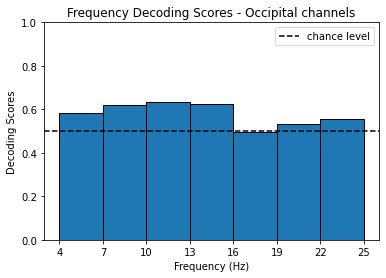

In [4]:
#Plot the result

%matplotlib inline
plt.bar(freqs[:-1], freq_scores, width=np.diff(freqs)[0],
        align='edge', edgecolor='black')
plt.xticks(freqs)
plt.ylim([0, 1])
plt.axhline(len(epochs['Relax']) / len(epochs), color='k', linestyle='--',
            label='chance level')
plt.legend()
plt.xlabel('Frequency (Hz)')
plt.ylabel('Decoding Scores')
plt.title('Frequency Decoding Scores - Occipital channels')
plt.show()

In [5]:
print(freq_scores) #average accuracies for 5-fold cross validation

[0.58333333 0.62       0.63333333 0.62666667 0.49666667 0.53333333
 0.55333333]


### Run the same analysis including all the EEG 14-channels

In [10]:
#delete the previous variables

del raw_datasets, raw, X, y, epo, epochs, include_channels, events, clf, freq_scores, raw_filter

In [11]:
#load datasets
raw_datasets = load_data(os.getcwd()) 


include_channels = ['AF3','F7','F3','FC5','T7','P7','O1','O2','P8','T8','FC6','F4','F8','AF4']   #all 14 channels
 

excl_chan(raw_datasets) #exclude channels

#crop sessions between 65 s and 165 s
for n_file in range (0,30):
    raw_datasets[n_file].crop(tmin=65.,tmax=164.998)
    
#concatenate sessions
raw = concatenate_raws(raw_datasets)

# Extract information from the raw file
sfreq = 256.

#create events
event_id = dict(Relax=0, Push=1)  #imagery relax vs push
events = mne.make_fixed_length_events(raw, id=0, start=0., stop=None, duration=10.)  
for n_events in range(0, len(events)):
    if n_events % 2 == 1: 
        events[n_events][2] = 1 
        
        

## Assemble the classifier using scikit-learn pipeline

clf = make_pipeline(CSP(n_components=4, reg=None, log=True, norm_trace=False), LinearDiscriminantAnalysis())

n_splits = 5  # how many folds to use for cross-validation
cv = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=42)


# Classification & time-frequency parameters
tmin, tmax = 0.5, 9.5
n_cycles = 2.   
min_freq = 4   
max_freq = 25 
n_freqs = 8  


# Assemble list of frequency range tuples

freqs = np.linspace(min_freq, max_freq, n_freqs)  # assemble frequencies
freq_ranges = list(zip(freqs[:-1], freqs[1:]))  # make freqs list of tuples


# Infer window spacing from the max freq and number of cycles to avoid gaps

window_spacing = (n_cycles / np.max(freqs) / 2.)
centered_w_times = np.arange(tmin, tmax, window_spacing)[1:]
n_windows = len(centered_w_times)

# init scores
freq_scores = np.zeros((n_freqs - 1,))


#Loop through frequencies, apply classifier and save scores
for freq, (fmin, fmax) in enumerate(freq_ranges):
        

    # Infer window size based on the frequency being used
    w_size = n_cycles / ((fmax + fmin) / 2.)  # in seconds
        
    raw_filter = raw.copy().filter(fmin, fmax, n_jobs=1, fir_design='firwin',
                                   skip_by_annotation='edge')


    # Extract epochs from filtered data, padded by window size
    epochs = mne.Epochs(raw_filter, events, event_id, tmin - w_size, tmax + w_size,proj=False, baseline=None, preload=True)
    epochs.drop_bad() #epochs.drop_bad(reject = dict(eeg = 200e-6)) #uncomment to include a rejection threshold

    epo=epochs_power(epochs)  #apply Morlet wavelet transform to the epoched filtered data
     
    y= epochs.events[:, 2]  #labels
    X = epo
  

    # Save mean scores over folds for each frequency and time window
    freq_scores[freq] = np.mean(cross_val_score(estimator=clf, X=X, y=y,
                                                scoring='accuracy', cv=cv,
                                                n_jobs=1), axis=0)

Extracting EDF parameters from /Users/ile/Documents/BCI_dataset/Giuseppe03_03.02.21_08.33.04.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 45311  =      0.000 ...   176.996 secs...
Extracting EDF parameters from /Users/ile/Documents/BCI_dataset/Giuseppe14_11.02.21_08.36.41.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 45567  =      0.000 ...   177.996 secs...
Extracting EDF parameters from /Users/ile/Documents/BCI_dataset/Giuseppe29_19.02.21_08.40.08.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 44543  =      0.000 ...   173.996 secs...
Extracting EDF parameters from /Users/ile/Documents/BCI_dataset/Giuseppe17_12.02.21_08.44.40.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 44799  =      0.000 ...   174.996 secs...
Extracting EDF parameters from /Users/ile/Do

Done.
Computing rank from data with rank=None
    Using tolerance 6.2e-09 (2.2e-16 eps * 14 dim * 2e+06  max singular value)
    Estimated rank (mag): 14
    MAG: rank 14 computed from 14 data channels with 0 projectors
Reducing data rank from 14 -> 14
Estimating covariance using EMPIRICAL
Done.
Computing rank from data with rank=None
    Using tolerance 9.9e-09 (2.2e-16 eps * 14 dim * 3.2e+06  max singular value)
    Estimated rank (mag): 14
    MAG: rank 14 computed from 14 data channels with 0 projectors
Reducing data rank from 14 -> 14
Estimating covariance using EMPIRICAL
Done.
Computing rank from data with rank=None
    Using tolerance 6.2e-09 (2.2e-16 eps * 14 dim * 2e+06  max singular value)
    Estimated rank (mag): 14
    MAG: rank 14 computed from 14 data channels with 0 projectors
Reducing data rank from 14 -> 14
Estimating covariance using EMPIRICAL
Done.
Computing rank from data with rank=None
    Using tolerance 9.9e-09 (2.2e-16 eps * 14 dim * 3.2e+06  max singular value

Reducing data rank from 14 -> 14
Estimating covariance using EMPIRICAL
Done.
Computing rank from data with rank=None
    Using tolerance 2.4e-09 (2.2e-16 eps * 14 dim * 7.7e+05  max singular value)
    Estimated rank (mag): 14
    MAG: rank 14 computed from 14 data channels with 0 projectors
Reducing data rank from 14 -> 14
Estimating covariance using EMPIRICAL
Done.
Computing rank from data with rank=None
    Using tolerance 2.4e-09 (2.2e-16 eps * 14 dim * 7.7e+05  max singular value)
    Estimated rank (mag): 14
    MAG: rank 14 computed from 14 data channels with 0 projectors
Reducing data rank from 14 -> 14
Estimating covariance using EMPIRICAL
Done.
Computing rank from data with rank=None
    Using tolerance 2.5e-09 (2.2e-16 eps * 14 dim * 8e+05  max singular value)
    Estimated rank (mag): 14
    MAG: rank 14 computed from 14 data channels with 0 projectors
Reducing data rank from 14 -> 14
Estimating covariance using EMPIRICAL
Done.
Computing rank from data with rank=None
    Us

    MAG: rank 14 computed from 14 data channels with 0 projectors
Reducing data rank from 14 -> 14
Estimating covariance using EMPIRICAL
Done.
Computing rank from data with rank=None
    Using tolerance 1.4e-09 (2.2e-16 eps * 14 dim * 4.4e+05  max singular value)
    Estimated rank (mag): 14
    MAG: rank 14 computed from 14 data channels with 0 projectors
Reducing data rank from 14 -> 14
Estimating covariance using EMPIRICAL
Done.
Computing rank from data with rank=None
    Using tolerance 4.8e-10 (2.2e-16 eps * 14 dim * 1.5e+05  max singular value)
    Estimated rank (mag): 14
    MAG: rank 14 computed from 14 data channels with 0 projectors
Reducing data rank from 14 -> 14
Estimating covariance using EMPIRICAL
Done.
Computing rank from data with rank=None
    Using tolerance 5.7e-10 (2.2e-16 eps * 14 dim * 1.8e+05  max singular value)
    Estimated rank (mag): 14
    MAG: rank 14 computed from 14 data channels with 0 projectors
Reducing data rank from 14 -> 14
Estimating covariance 

    Estimated rank (mag): 14
    MAG: rank 14 computed from 14 data channels with 0 projectors
Reducing data rank from 14 -> 14
Estimating covariance using EMPIRICAL
Done.


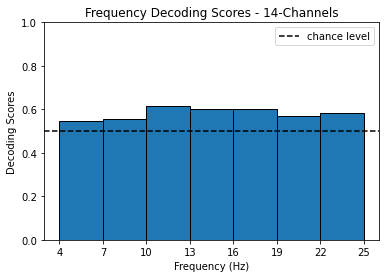

In [12]:
#Plot the result

#%matplotlib inline
plt.bar(freqs[:-1], freq_scores, width=np.diff(freqs)[0],
        align='edge', edgecolor='black')
plt.xticks(freqs)
plt.ylim([0, 1])
plt.axhline(len(epochs['Relax']) / len(epochs), color='k', linestyle='--',
            label='chance level')
plt.legend()
plt.xlabel('Frequency (Hz)')
plt.ylabel('Decoding Scores')
plt.title('Frequency Decoding Scores - 14-Channels')
plt.show()

In [13]:
print(freq_scores) #average accuracies for 5-fold cross validation

[0.54666667 0.55666667 0.61333333 0.6        0.60333333 0.57
 0.58333333]
